## **Project: Company Bankruptcy Prediction**

Team members: Sharjeel Nawaz, Siddhesh Mishra, Tirth Shah


### **Project Scope**

This project aims to develop a machine learning model using PySpark to predict the likelihood of a company filing for bankruptcy. The model will be trained on historical financial data, incorporating factors such as profitability, liquidity, and solvency ratios.

### **Objectives:**

Leverage PySpark's distributed computing capabilities to efficiently handle large datasets of financial information.
Build a classification model to identify companies at high risk of bankruptcy.
Evaluate the model's performance using relevant metrics.
Gain insights into the financial factors that contribute most significantly to bankruptcy prediction.

### **Data**

#### **Internal Data:**

The project will utilize a pre-existing dataset containing company financial data, potentially including the following features:

ROA(C) before interest and depreciation before interest: Return on Assets before interest and depreciation.
Operating Gross Margin: Ratio of gross profit to sales revenue.
Current Ratio: Measure of a company's ability to meet short-term obligations.
Quick Ratio: More stringent measure of liquidity than the current ratio.
Debt Ratio (%): Ratio of total liabilities to total assets, indicating financial leverage.
After-tax Net Profit Growth Rate: Percentage change in net profit over a period.

#### **External Data (Optional):**

In addition to the internal data, we can consider fetching additional financial information from Yahoo Finance using the yfinance library:

Stock price history
Market capitalization
Other relevant financial ratios

#### **Constraints:**

Data Availability: Access to historical data from Yahoo Finance which has already filled bankruptcy might be limited by API usage restrictions or data availability for certain companies.

**1.  Install Packages:**



In [1]:
# Installing required packages

!pip install pyspark
!pip install -q kaggle

**2. Import libraries:**

In [2]:
# importing necessary libraries
from google.colab import files
import pyspark
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import col, sum as spark_sum
import matplotlib.pyplot as plt

# importing necessary ml libraries
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler,StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# data scrapping libraries
import yfinance as yf

In [3]:
# Uploading kaggle key file for access to kaggle datasets
files.upload()

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets list

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                 title                                    size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------  --------------------------------------  -----  -------------------  -------------  ---------  ---------------  
syedanwarafridi/vehicle-sales-data                  Vehicle Sales Data                       19MB  2024-02-21 20:16:17           9995        182  1.0              
arnavvvvv/spotify-music                             Top Spotify Songs                        47KB  2024-03-06 05:20:29           1755         37  1.0              
tarunrm09/climate-change-indicators                 Climate change Indicators                34KB  2024-02-22 08:53:54           5201        114  1.0              
arnavvvvv/netflix-movies-and-tv-shows               Netflix Movies and TV Shows   

In [4]:
# Downloading the company bankruptcy data from kaggle

!kaggle datasets download -d fedesoriano/company-bankruptcy-prediction

company-bankruptcy-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
# Unzipping the dataset
!unzip 'company-bankruptcy-prediction.zip'

Archive:  company-bankruptcy-prediction.zip
replace data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: data.csv                


In [6]:
# from pyspark.sql.session import SparkSession
session=SparkSession.builder.appName("bankrupt").master("local[2]").getOrCreate()
data=session.read.csv("data.csv", header=True, inferSchema=True)
data.columns

['Bankrupt?',
 ' ROA(C) before interest and depreciation before interest',
 ' ROA(A) before interest and % after tax',
 ' ROA(B) before interest and depreciation after tax',
 ' Operating Gross Margin',
 ' Realized Sales Gross Margin',
 ' Operating Profit Rate',
 ' Pre-tax net Interest Rate',
 ' After-tax net Interest Rate',
 ' Non-industry income and expenditure/revenue',
 ' Continuous interest rate (after tax)',
 ' Operating Expense Rate',
 ' Research and development expense rate',
 ' Cash flow rate',
 ' Interest-bearing debt interest rate',
 ' Tax rate (A)',
 ' Net Value Per Share (B)',
 ' Net Value Per Share (A)',
 ' Net Value Per Share (C)',
 ' Persistent EPS in the Last Four Seasons',
 ' Cash Flow Per Share',
 ' Revenue Per Share (Yuan ¥)',
 ' Operating Profit Per Share (Yuan ¥)',
 ' Per Share Net profit before tax (Yuan ¥)',
 ' Realized Sales Gross Profit Growth Rate',
 ' Operating Profit Growth Rate',
 ' After-tax Net Profit Growth Rate',
 ' Regular Net Profit Growth Rate',
 ' C

**3. Data Cleaning**

In [7]:
# Cleaning the data according to the requirements

data = data.withColumn(" Current Ratio", col(" Current Ratio") * 1000)
data = data.withColumn(" Quick Ratio", col(" Quick Ratio") * 1000)

In [8]:
data.select(' Quick Ratio', ' Current Ratio').show(5)

+------------------+------------------+
|       Quick Ratio|     Current Ratio|
+------------------+------------------+
|1.2077550852353198|  2.25896331056689|
|  4.03936682691048| 6.016205877672769|
| 5.347560222436551|11.542553689380101|
|  2.89649114708036|    4.194058676884|
|  3.72744660861623|  6.02244610781246|
+------------------+------------------+
only showing top 5 rows



In [9]:
# Selecting only necessary columns for model training

clean_data = data.select(' ROA(C) before interest and depreciation before interest',' Operating Gross Margin',  ' Current Ratio', ' Quick Ratio', ' Debt ratio %', ' After-tax Net Profit Growth Rate', 'Bankrupt?')
clean_data.show(5)

+--------------------------------------------------------+-----------------------+------------------+------------------+-----------------+---------------------------------+---------+
| ROA(C) before interest and depreciation before interest| Operating Gross Margin|     Current Ratio|       Quick Ratio|     Debt ratio %| After-tax Net Profit Growth Rate|Bankrupt?|
+--------------------------------------------------------+-----------------------+------------------+------------------+-----------------+---------------------------------+---------+
|                                       0.370594257300249|      0.601457213277793|  2.25896331056689|1.2077550852353198|0.207576261450555|                0.688979462807371|        1|
|                                       0.464290937454297|      0.610235085544617| 6.016205877672769|  4.03936682691048|0.171176346101521|                0.689692901209989|        1|
|                                       0.426071271876371|      0.601450006486113|11.

In [10]:
# Checking for null values in any columns

null_counts = clean_data.select([spark_sum(col(c).isNull().cast('integer')).alias(c) for c in clean_data.columns])
null_counts.show()

+--------------------------------------------------------+-----------------------+--------------+------------+-------------+---------------------------------+---------+
| ROA(C) before interest and depreciation before interest| Operating Gross Margin| Current Ratio| Quick Ratio| Debt ratio %| After-tax Net Profit Growth Rate|Bankrupt?|
+--------------------------------------------------------+-----------------------+--------------+------------+-------------+---------------------------------+---------+
|                                                       0|                      0|             0|           0|            0|                                0|        0|
+--------------------------------------------------------+-----------------------+--------------+------------+-------------+---------------------------------+---------+



In [11]:
unique_values = clean_data.select('Bankrupt?').distinct()
unique_values.show()

+---------+
|Bankrupt?|
+---------+
|        1|
|        0|
+---------+



# Data Visualization

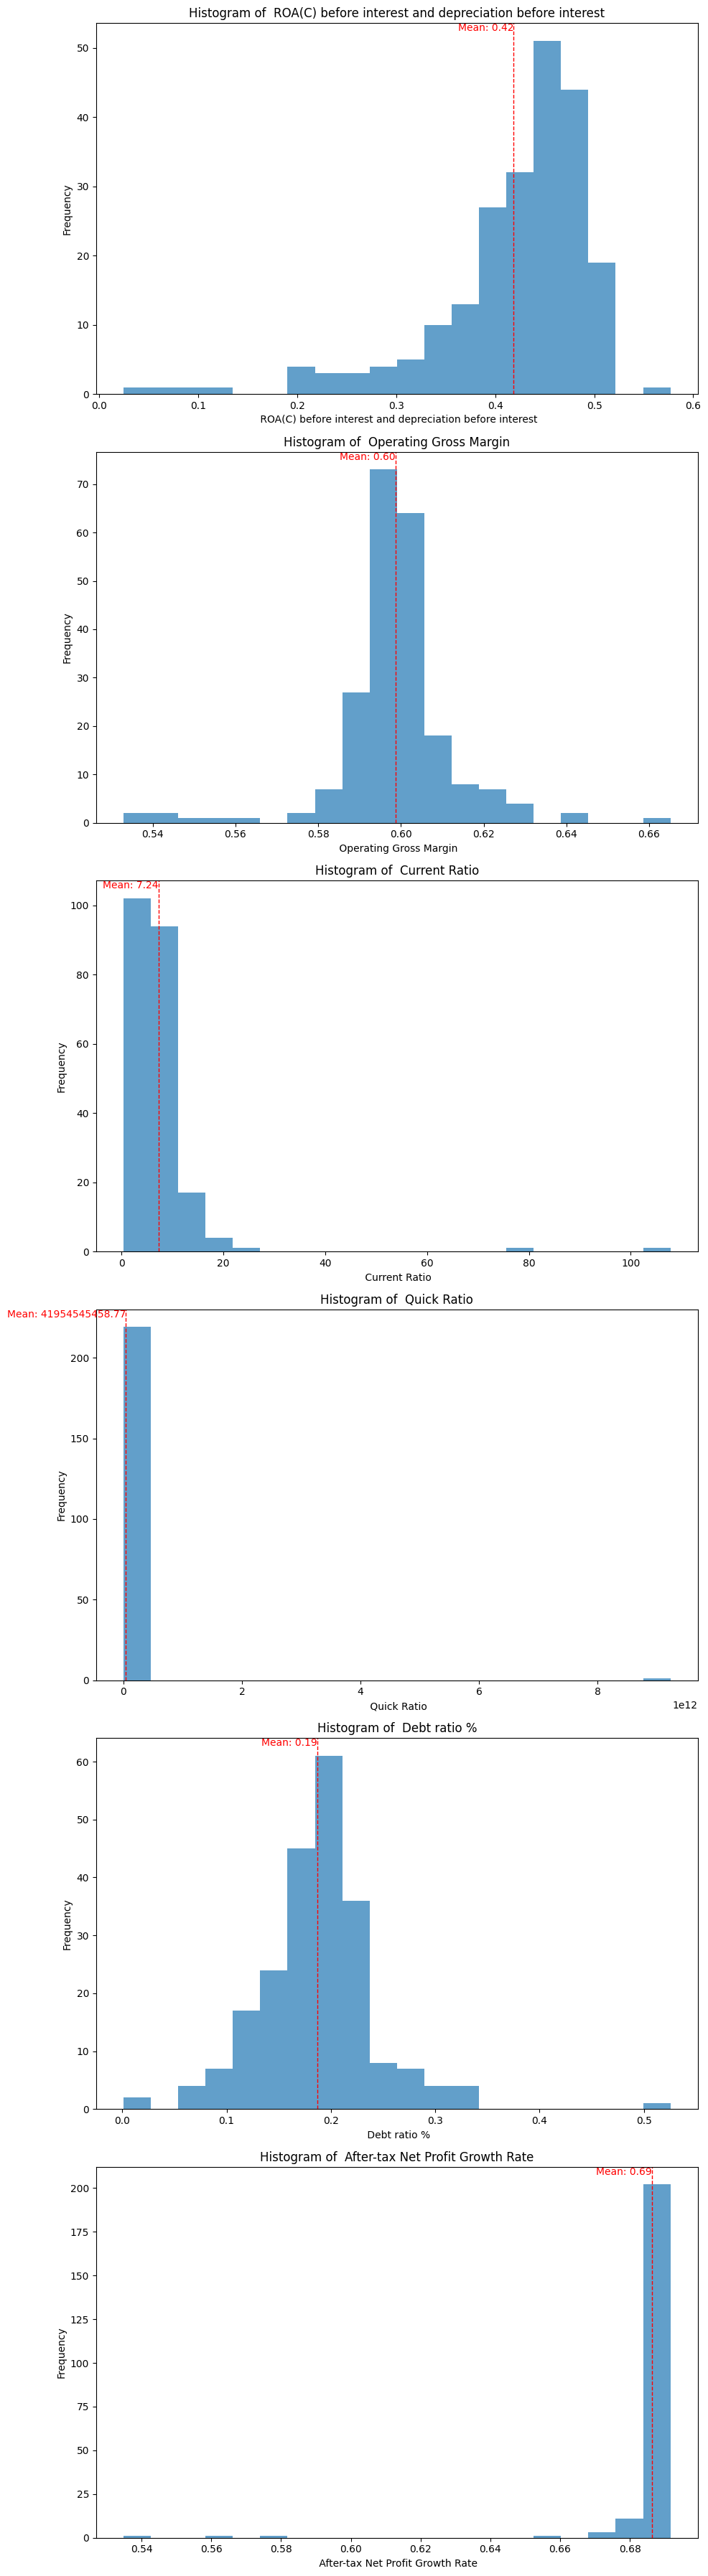

In [12]:
# Filter rows where 'Bankrupt?' column is equal to 1
bankrupt_data = clean_data.filter(clean_data["Bankrupt?"] == 1)

import pyspark.sql.functions as F

# Define the list of columns to visualize (excluding the 'Bankrupt?' column)
columns_to_visualize = [col for col in bankrupt_data.columns if col != 'Bankrupt?']

# Calculate the number of rows in the DataFrame
num_rows = bankrupt_data.count()

# Set up the figure and axis
fig, axes = plt.subplots(nrows=len(columns_to_visualize), ncols=1, figsize=(10, 6*len(columns_to_visualize)))

# Iterate over each column and create a histogram
for i, column in enumerate(columns_to_visualize):
    ax = axes[i]

    # Extract the column data and convert it to a list
    column_data = bankrupt_data.select(column).rdd.flatMap(lambda x: x).collect()

    # Plot histogram
    ax.hist(column_data, bins=20, alpha=0.7)

    # Add title and labels
    ax.set_title(f"Histogram of {column}")
    ax.set_xlabel(column)
    ax.set_ylabel("Frequency")

    # Add mean value as a vertical line
    mean_value = sum(column_data) / num_rows
    ax.axvline(mean_value, color='red', linestyle='dashed', linewidth=1)
    ax.text(mean_value, ax.get_ylim()[1], f'Mean: {mean_value:.2f}', color='red', ha='right', va='top')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

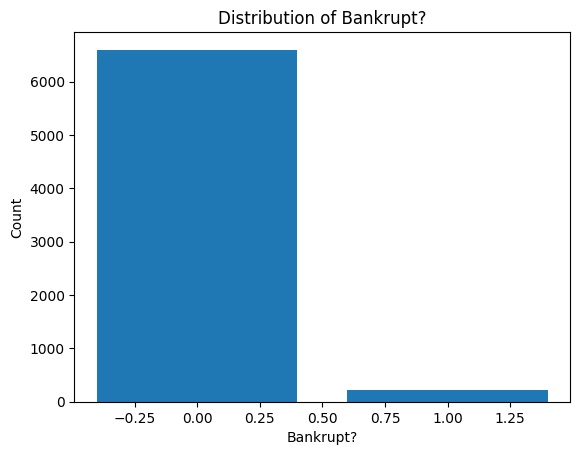

In [17]:
bankrupt_counts = clean_data.groupBy('Bankrupt?').count().orderBy('Bankrupt?')

# Extracting counts and labels
labels = bankrupt_counts.select('Bankrupt?').rdd.flatMap(lambda x: x).collect()
counts = bankrupt_counts.select('count').rdd.flatMap(lambda x: x).collect()


plt.bar(labels, counts)
plt.xlabel('Bankrupt?')
plt.ylabel('Count')
plt.title('Distribution of Bankrupt?')
plt.show()


# Data Preprocessing

In [13]:
# from pyspark.sql.functions import col

def balance_classes(df, label_col, minority_class_size):
    # Count the number of instances for each class
    counts = df.groupBy(label_col).count().collect()

    # Find the minority class label
    minority_class_label = min(counts, key=lambda x: x['count'])[label_col]

    # Calculate the size of the majority class
    majority_class_size = df.filter(col(label_col) != minority_class_label).count()

    # Calculate the sampling fraction for undersampling the majority class
    sampling_fraction = minority_class_size / majority_class_size

    # Undersample the majority class
    sampled_majority = df.filter(col(label_col) != minority_class_label).sample(withReplacement=False, fraction=sampling_fraction)

    # Combine the minority class with the undersampled majority class
    balanced_df = sampled_majority.union(df.filter(col(label_col) == minority_class_label))

    return balanced_df


# Assuming 'data' is your DataFrame and 'label_col' is the name of the label column
balanced_data = balance_classes(clean_data, 'Bankrupt?', 1000)


In [14]:
from pyspark.sql.functions import corr

# Calculate correlation between 'Bankrupt?' and other numeric columns
correlation_matrix = balanced_data.select([corr('Bankrupt?', col).alias(col) for col in balanced_data.columns if col != 'Bankrupt?'])

# Show the correlation matrix
correlation_matrix.show()

+--------------------------------------------------------+-----------------------+--------------------+-------------------+------------------+---------------------------------+
| ROA(C) before interest and depreciation before interest| Operating Gross Margin|       Current Ratio|        Quick Ratio|      Debt ratio %| After-tax Net Profit Growth Rate|
+--------------------------------------------------------+-----------------------+--------------------+-------------------+------------------+---------------------------------+
|                                     -0.4961125014655831|   -0.24990550595533997|-0.01343412821391...|0.04457225477381159|0.4963363816901455|             -0.13742803702835965|
+--------------------------------------------------------+-----------------------+--------------------+-------------------+------------------+---------------------------------+



In [15]:
columns = [' ROA(C) before interest and depreciation before interest',' Operating Gross Margin',  ' Current Ratio', ' Quick Ratio', ' Debt ratio %', ' After-tax Net Profit Growth Rate']

In [16]:
balanced_data.show(5)

+--------------------------------------------------------+-----------------------+------------------+------------------+------------------+---------------------------------+---------+
| ROA(C) before interest and depreciation before interest| Operating Gross Margin|     Current Ratio|       Quick Ratio|      Debt ratio %| After-tax Net Profit Growth Rate|Bankrupt?|
+--------------------------------------------------------+-----------------------+------------------+------------------+------------------+---------------------------------+---------+
|                                       0.390922829425243|      0.619949840729904|  4.67206030558407|2.8690421678704703| 0.216101823019016|                0.688589850304315|        0|
|                                       0.506703066348169|      0.604685855950648|18.859223528163703|    12.02327673437|0.0896393264201711|                0.689922346416557|        0|
|                                       0.504070589382343|      0.59834387927182

In [17]:
# Vector Assembling
assembler = VectorAssembler(inputCols=columns, outputCol="newFeatures")

pipeline = Pipeline(stages=[assembler])
newData=pipeline.fit(balanced_data).transform(balanced_data)
newData.select('newFeatures').show(5)

+--------------------+
|         newFeatures|
+--------------------+
|[0.39092282942524...|
|[0.50670306634816...|
|[0.50407058938234...|
|[0.51928045629600...|
|[0.49436942426753...|
+--------------------+
only showing top 5 rows



In [18]:
# Creating a logistic regression model
lr = LogisticRegression(featuresCol='newFeatures', labelCol="Bankrupt?")

#Creating a pipeline
lrpipeline=Pipeline(stages=[assembler, lr])

#Splitting the dataset in training and test
training, test=balanced_data.randomSplit([0.75,0.25],seed=123)

#Training the model
lrmodel=lrpipeline.fit(training)

#Predicting the results on test dataset
lrresults=lrmodel.transform(test)

#Displaying the results
lrresults.show(22,truncate=False)

+--------------------------------------------------------+-----------------------+------------------+------------------+------------------+---------------------------------+---------+--------------------------------------------------------------------------------------------------------------+------------------------------------------+-----------------------------------------+----------+
| ROA(C) before interest and depreciation before interest| Operating Gross Margin| Current Ratio    | Quick Ratio      | Debt ratio %     | After-tax Net Profit Growth Rate|Bankrupt?|newFeatures                                                                                                   |rawPrediction                             |probability                              |prediction|
+--------------------------------------------------------+-----------------------+------------------+------------------+------------------+---------------------------------+---------+-----------------------------------

In [19]:
#Evaluting the Results

#Considering prediction
lreval=BinaryClassificationEvaluator(rawPredictionCol="prediction",labelCol="Bankrupt?")
lreval.evaluate(lrresults)

0.7376543209876544

In [20]:
#Determining the accuracy
lrresults=lrresults.withColumn("compare",lrresults['Bankrupt?']-lrresults['prediction'])
correct=lrresults.filter(lrresults['compare']==0).count()
incorrect=lrresults.filter(lrresults['compare']!=0).count()
print(correct/(correct+incorrect))

0.8915254237288136


**Model verification using actual data**

Importing the data from yahoo finance using the stock symbol like AAPL,  MSFT, NVDA

In [33]:
ticker = input ('Please enter your ticker name : ')

Please enter your ticker name : GRMN


In [34]:
# Storing all the information of the company
data2 = yf.Ticker(ticker).info

In [35]:
# Creating a dataset with required variables
test_data = [str(data2.get('shortName')), float(data2.get('returnOnAssets')), float(data2.get('grossMargins')), float(data2.get('currentRatio')), float(data2.get('quickRatio')), float(data2.get('debtToEquity')), float(data2.get('earningsGrowth'))]

from pyspark.sql.types import StructType, StringType, DoubleType
from pyspark.sql.types import StructField, StructType

company_schema = StructType([
    StructField(' Company', StringType(), True),
    StructField(' ROA(C) before interest and depreciation before interest', DoubleType(), True),
    StructField(' Operating Gross Margin', DoubleType(), True),
    StructField(' Current Ratio', DoubleType(), True),
    StructField(' Quick Ratio', DoubleType(), True),
    StructField(' After-tax Net Profit Growth Rate', DoubleType(), True),
    StructField(' Debt ratio %', DoubleType(), True),


])

company_data = session.createDataFrame([], company_schema)

from pyspark.sql import SparkSession, Row  # Import Row along with SparkSession



# Convert the list to a Row object
new_row_as_row = Row(*test_data)

# Append the new row using union with a DataFrame containing the single row
use_case_df = company_data.union(session.createDataFrame([test_data]))

# Vector assemble the data
assembler = VectorAssembler(inputCols=columns, outputCol="usecasefeatures")
pipeline = Pipeline(stages=[assembler])
usecase_newData=pipeline.fit(use_case_df).transform(use_case_df)


In [36]:
# Predicting the result of desired company
usecase_results=lrmodel.transform(usecase_newData)
usecase_results.select(' Company','prediction').show(2,truncate=False)


+-----------+----------+
| Company   |prediction|
+-----------+----------+
|Garmin Ltd.|1.0       |
+-----------+----------+



Prediction value meaning.

0 ---> Solvent - The company is predicted to not be bankrupt

1 ---> Bankrupt - The company is predicted to be bankrupt
